# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 8

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: `predict_proba` возвращает вероятности. 

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


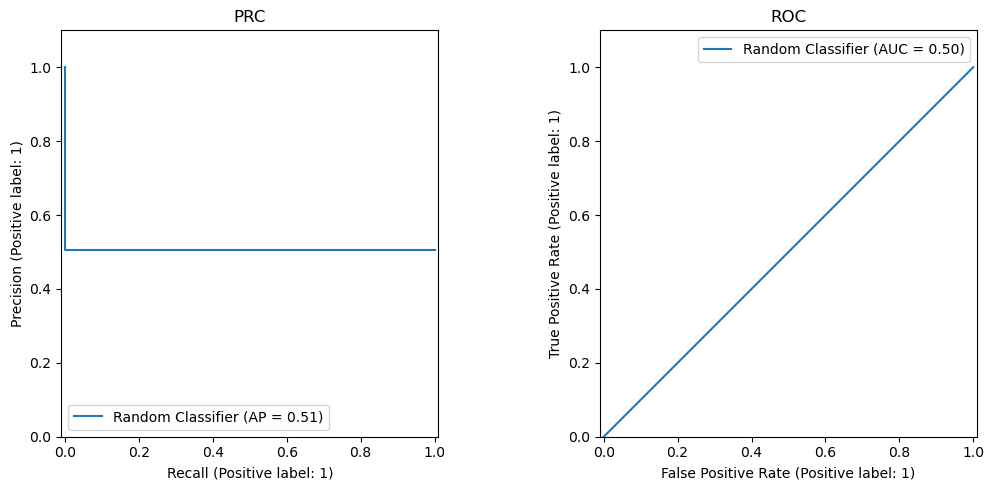

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [7]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [8]:
from sklearn.svm import LinearSVC

C = np.logspace(-9, 0, 10)
C_best = 0
auc_pr_best = 0
for c in C:
    model = LinearSVC(dual='auto', C=c)
    model.fit(X_train, y_train)
    auc_pr = average_precision_score(y_val, model.decision_function(X_val))
    if auc_pr_best < auc_pr:
        auc_pr_best = auc_pr
        C_best = c

In [9]:
C_best

1e-05

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

LinearSVC metrics
AUC-PR: 0.8237
AUC-ROC: 0.8333


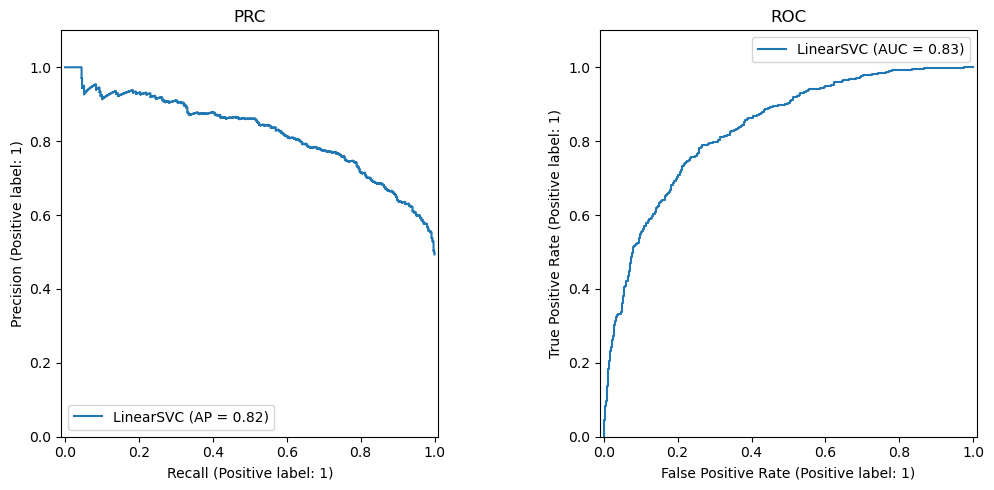

In [10]:
model = LinearSVC(dual='auto', C=C_best)
model.fit(X_train, y_train)
depict_pr_roc(y_test, model.decision_function(X_test), 'LinearSVC')

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [11]:
precision, recall, _ = precision_recall_curve(y_test, model.decision_function(X_test))
df_metrics.loc['LinearSVC'] = [
      average_precision_score(y_test, model.decision_function(X_test)),
      roc_auc_score(y_test, model.decision_function(X_test)),
      0,
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0
LinearSVC,0.823681,0.833327,0.0


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [12]:
from sklearn.linear_model import LogisticRegression

C = np.logspace(-9, 0, 10)
C_best = 0
auc_pr_best = 0
for c in C:
    model = LogisticRegression(C=c)
    model.fit(X_train, y_train)
    auc_pr = average_precision_score(y_val, model.decision_function(X_val))
    if auc_pr_best < auc_pr:
        auc_pr_best = auc_pr
        C_best = c

In [13]:
C_best

0.001

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

LinearSVC metrics
AUC-PR: 0.8256
AUC-ROC: 0.8487


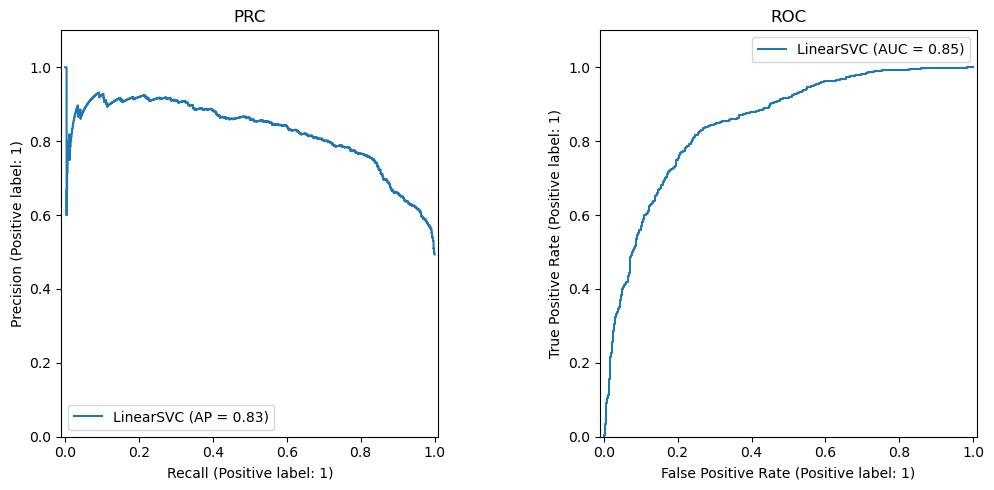

In [14]:
model = LinearSVC(dual='auto', C=C_best)
model.fit(X_train, y_train)
depict_pr_roc(y_test, model.decision_function(X_test), 'LinearSVC')

In [15]:
precision, recall, _ = precision_recall_curve(y_test, model.decision_function(X_test))
df_metrics.loc['LogisticRegression'] = [
      average_precision_score(y_test, model.decision_function(X_test)),
      roc_auc_score(y_test, model.decision_function(X_test)),
      0,
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0
LinearSVC,0.823681,0.833327,0.0
LogisticRegression,0.825641,0.848693,0.0


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Вообще, результаты очень похожие. И всё же у `LogisticRegression` результат чут-чуть получше.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [16]:
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42
)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [18]:
from sklearn.svm import SVC
C = np.logspace(-9, 0, 10)
C_best = 0
auc_pr_best = 0
for c in C:
    model = SVC(C=c, kernel='linear')
    model.fit(X_train, y_train)
    auc_pr = average_precision_score(y_val, model.decision_function(X_val))
    if auc_pr_best < auc_pr:
        auc_pr_best = auc_pr
        C_best = c

In [19]:
model = SVC(C=C_best, kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

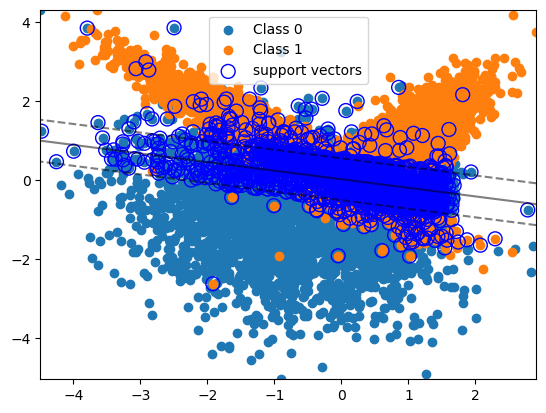

In [20]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(YY.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(
        x=X[y==0,0], y=X[y==0,1],
        label='Class 0'
    )
    plt.scatter(
        x=X[y==1,0], y=X[y==1,1],
        label='Class 1'
    )

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(
            model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** # your answer here

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [21]:
C = np.logspace(-9, 0, 10)
C_best = 0
auc_pr_best = 0
for c in C:
    model = LogisticRegression(C=c)
    model.fit(X_train, y_train)
    auc_pr = average_precision_score(y_val, model.decision_function(X_val))
    if auc_pr_best < auc_pr:
        auc_pr_best = auc_pr
        C_best = c

In [22]:
model = LogisticRegression(C=C_best)
model.fit(X_train, y_train)

LogisticRegression()

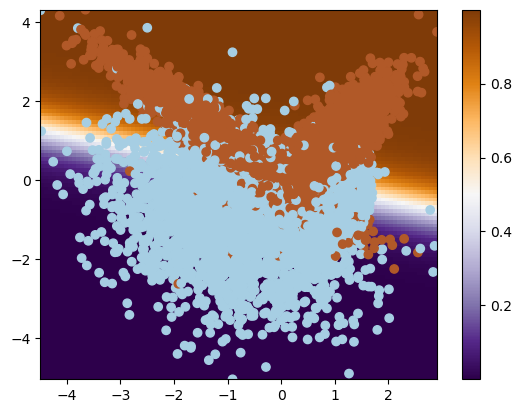

In [23]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
        X[:, 0], X[:, 1], 
        c=y, 
        cmap=plt.cm.Paired
    )

    plt.colorbar(image)

plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Белая линия. 

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [24]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [25]:
# your code here
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [26]:
C = np.logspace(-9, 0, 10)
C_best = 0
auc_pr_best = 0
for c in C:
    model = LinearSVC(dual='auto', C=c)
    model.fit(X_train, y_train)
    auc_pr = average_precision_score(y_val, model.decision_function(X_val))
    if auc_pr_best < auc_pr:
        auc_pr_best = auc_pr
        C_best = c

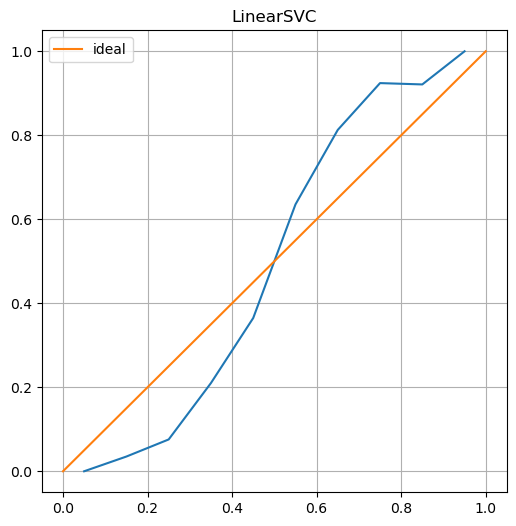

In [27]:
model_svc = LinearSVC(dual='auto', C=C_best)
model_svc.fit(X_train, y_train)
pred_svc = model_svc.decision_function(X_test)
pred_svc = (pred_svc - pred_svc.min()) / (pred_svc.max() - pred_svc.min())
plot_calibration_curve(y_test, pred_svc)
plt.plot([0, 1], [0, 1], label='ideal')
plt.legend()
plt.title('LinearSVC')
plt.show()

In [28]:
C = np.logspace(-9, 0, 10)
C_best = 0
auc_pr_best = 0
for c in C:
    model = LogisticRegression(C=c)
    model.fit(X_train, y_train)
    auc_pr = average_precision_score(y_val, model.decision_function(X_val))
    if auc_pr_best < auc_pr:
        auc_pr_best = auc_pr
        C_best = c

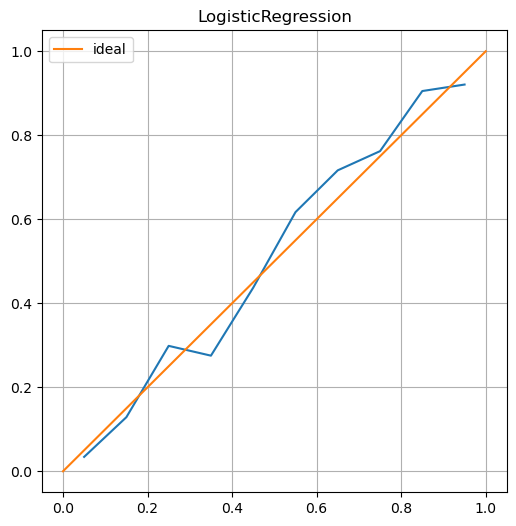

In [29]:
model_lr = LogisticRegression(C=C_best)
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict_proba(X_test)[:,1]
plot_calibration_curve(y_test, pred_lr)
plt.plot([0, 1], [0, 1], label='ideal')
plt.legend()
plt.title('LogisticRegression')
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** кажется, что `LogisticRegression` намного лучше откалибрована, чем `LinearSVC`. Это видно по отплонению кивых от идеальной линии.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [30]:
# your code here
from sklearn.metrics import log_loss, brier_score_loss

print(log_loss(y_test, pred_svc), brier_score_loss(y_test, pred_svc))
print(log_loss(y_test, pred_lr), brier_score_loss(y_test, pred_lr))

0.5482329691547662 0.18284333872183492
0.4900601810856526 0.1607436697803606


Изучите распределение ответов классификаторов при помощи гистограмм

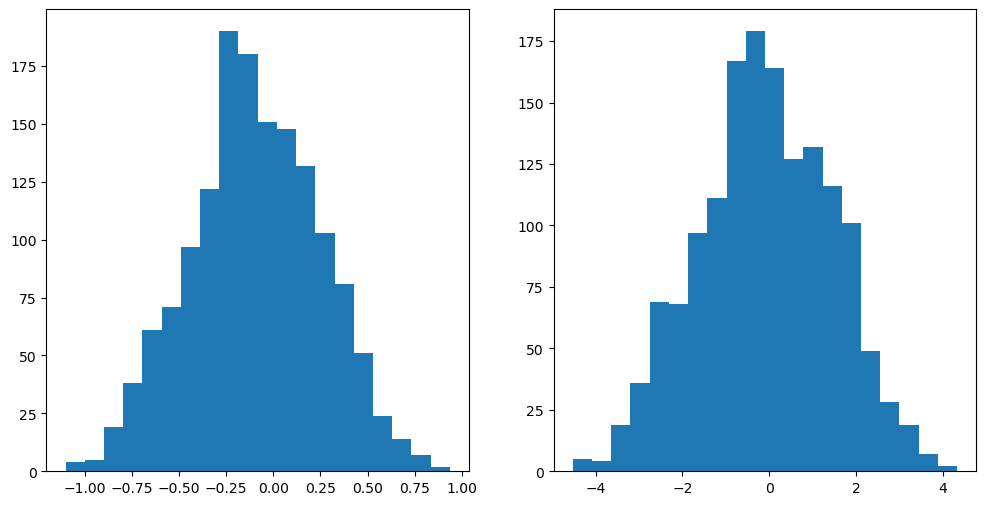

In [31]:
# your code here
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].hist(model_svc.decision_function(X_test), bins=20)
ax[1].hist(model_lr.decision_function(X_test), bins=20)
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Да особо ни чем, разбросом разве что. 

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

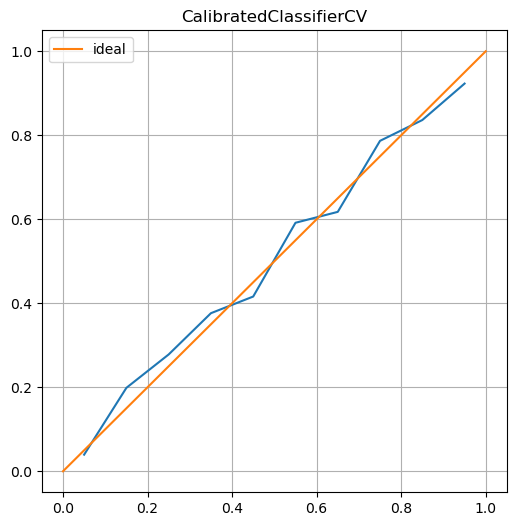

In [32]:
from sklearn.calibration import CalibratedClassifierCV

model = CalibratedClassifierCV(model_svc, cv=3)
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)[:,1]
plot_calibration_curve(y_test, pred)
plt.plot([0, 1], [0, 1], label='ideal')
plt.legend()
plt.title('CalibratedClassifierCV')
plt.show()

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Да, улучшились.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [33]:
# your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [451]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [452]:
# Прочитаем датасет
# your code here
df = pd.read_csv(path)

# Заменим пропуски категориальных переменных
for x in df.select_dtypes(include='object'):
    df[x] = df[x].fillna('undefined')

for x in df.select_dtypes(include='number'):
    df[x] = df[x].fillna(0)

# Отделим X и y
df['Purchased Bike'] = df['Purchased Bike'].replace({'No': 0, 'Yes': 1})
y = df['Purchased Bike']
X = df.drop(columns=['Purchased Bike'])

# Разделим на категориальные признаки и числовые
X_numerical = X.select_dtypes(include='number')
X_categorical = X.select_dtypes(exclude='number')

В начале поработаем только с категориальными признаками

In [453]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [454]:
# your code here
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import time

column_transformer = ColumnTransformer([
    ('ohe', OrdinalEncoder(), X_categorical.columns.to_list()),
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

start = time.time()
model = pipeline.fit(X_train, y_train)
finish = time.time()

print(f'PR-AUC: {average_precision_score(y_test, model.decision_function(X_test))}')
print('Time:', finish - start)

PR-AUC: 0.5886533539773633
Time: 0.007817983627319336


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [455]:
# your code here
from sklearn.preprocessing import OneHotEncoder
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_categorical.columns.to_list()),
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

start = time.time()
model = pipeline.fit(X_train, y_train)
finish = time.time()

print(f'PR-AUC: {average_precision_score(y_test, model.decision_function(X_test))}')
print('Time:', finish - start)

PR-AUC: 0.6662544177340515
Time: 0.008535146713256836


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [456]:
# your code here
from sklearn.preprocessing import FunctionTransformer

def g(df, columns):
    for col in columns:
        df[col] = df[col].map(y_train.groupby(X_train[col]).mean())
    return df

MeanTargetEncoding = FunctionTransformer(g, kw_args={'columns': X_categorical.columns.to_list()})

column_transformer = ColumnTransformer([
    ('mte', MeanTargetEncoding, X_categorical.columns.to_list()),
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

start = time.time()
model = pipeline.fit(X_train, y_train)
finish = time.time()

print(f'PR-AUC: {average_precision_score(y_test, model.decision_function(X_test))}')
print('Time:', finish - start)

PR-AUC: 0.6575110261581697
Time: 0.008555889129638672


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [457]:
# your code here

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [458]:
# your code here
def g(df, columns):
    for col in columns:
        df[col] = df[col].map(y_train.groupby(X_train[col]).mean()) + np.random.normal(0, 1)
    return df

MeanTargetEncoding = FunctionTransformer(g, kw_args={'columns': X_categorical.columns.to_list()})

column_transformer = ColumnTransformer([
    ('mte', MeanTargetEncoding, X_categorical.columns.to_list()),
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

start = time.time()
model = pipeline.fit(X_train, y_train)
finish = time.time()

print(f'PR-AUC: {average_precision_score(y_test, model.decision_function(X_test))}')
print('Time:', finish - start)

PR-AUC: 0.6582017254158314
Time: 0.008952856063842773


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Да не особо, показатели почти что вообще не изменились.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [459]:
# your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global\_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global\_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [460]:
# your code here
def g(df, columns):
    for col in columns:
        df[col] = df[col].map(y_train.groupby(X_train[col]).mean() + 0.1 * y_train.mean() * len(y_train.groupby(X_train[col]))) 
    return df

MeanTargetEncoding = FunctionTransformer(g, kw_args={'columns': X_categorical.columns.to_list()})

column_transformer = ColumnTransformer([
    ('mte', MeanTargetEncoding, X_categorical.columns.to_list()),
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

start = time.time()
model = pipeline.fit(X_train, y_train)
finish = time.time()

print(f'PR-AUC: {average_precision_score(y_test, model.decision_function(X_test))}')
print('Time:', finish - start)

PR-AUC: 0.6623383317169483
Time: 0.010571002960205078


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [461]:
# your code here
def g(df, columns):
    for col in columns:
        df[col] = df[col].map(y_train.groupby(X_train[col]).mean() + 0.1 * y_train.mean() * len(y_train.groupby(X_train[col]))) 
    return df

MeanTargetEncoding = FunctionTransformer(g, kw_args={'columns': X_categorical.columns.to_list()})

column_transformer = ColumnTransformer([
    ('mte', MeanTargetEncoding, X_categorical.columns.to_list()),
    ('scaling', StandardScaler(), X_numerical.columns.to_list())
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

start = time.time()
model = pipeline.fit(X_train, y_train)
finish = time.time()

print(f'PR-AUC: {average_precision_score(y_test, model.decision_function(X_test))}')
print('Time:', finish - start)

PR-AUC: 0.7176389243420266
Time: 0.012730121612548828


 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [489]:
def g(df, columns):
    for col in columns:
        df[col] = df[col].map(y_train.groupby(X_train[col]).mean() + 10 * y_train.mean() * len(y_train.groupby(X_train[col]))).fillna(0)
    return df

column_transformer = ColumnTransformer([
    ('mte', FunctionTransformer(g, kw_args={'columns': X_categorical.columns.to_list()}), X_categorical.columns.to_list()),
    ('scaling', FunctionTransformer(g, kw_args={'columns': X_numerical.columns.to_list()}), X_numerical.columns.to_list())
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

start = time.time()
model = pipeline.fit(X_train, y_train)
finish = time.time()

print(f'PR-AUC: {average_precision_score(y_test, model.decision_function(X_test))}')
print('Time:', finish - start)

PR-AUC: 0.6919684164150983
Time: 0.021840810775756836


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Меньше памяти занимают, меньше времени тратят и вообще с кайфом все происходит. 

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [46]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-12-02 12:33:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «adult.data.3»

adult.data.3            [          <=>       ]   3,79M  1,25MB/s    за 3,0s    

2024-12-02 12:34:02 (1,25 MB/s) - «adult.data.3» сохранён [3974305]



In [579]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
27614,63,Self-emp-not-inc,168048,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,30,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [580]:
# your code here
X_train, X_test, y_train, y_test = train_test_split(df.drop(['income'], axis=1), df['income'], test_size=0.25, random_state=777, stratify=df['income'])

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [581]:
# your code here
X_numerical = df.drop(['income'], axis=1).select_dtypes(include='number')
X_categorical = df.drop(['income'], axis=1).select_dtypes(exclude='number')

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_categorical.columns.to_list()),
    ('scaling', StandardScaler(), X_numerical.columns.to_list()),
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
])

model = pipeline.fit(X_train, y_train)
print(f"New: {column_transformer.transform(X_train).shape[1] - X_train.shape[1]}")

New: 94


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [582]:
# your code here
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

start = time.time()
model = pipeline.fit(X_train, y_train)
finish = time.time()

print(f'PR-AUC: {average_precision_score(y_test, model.decision_function(X_test))}')
print('Time:', finish - start)

PR-AUC: 0.7672341309944473
Time: 0.12425017356872559


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [583]:
# your code here
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=777, stratify=y_train)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [584]:
# your code here
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_categorical.columns.to_list()),
    ('scaling', StandardScaler(), X_numerical.columns.to_list()),
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

model = pipeline.fit(X_val, y_val)

In [585]:
class top_abs():
    def __init__(self, w):
        super().__init__()
        self.i = np.argsort(w)[-40:]
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        return X_[:, self.i]


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_categorical.columns.to_list()),
    ('scaling', StandardScaler(), X_numerical.columns.to_list()),
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('top_abs', top_abs(np.abs(model['regression'].coef_[0]))),
    ('regression', LogisticRegression()),
])

start = time.time()
model = pipeline.fit(X_train, y_train)
finish = time.time()

print(f'PR-AUC: {average_precision_score(y_test, model.decision_function(X_test))}')
print('Time:', finish - start)

PR-AUC: 0.6770792665222173
Time: 0.06926107406616211


Изменилось ли качество? Как?

Качество ухудшилось, что в целом ожидаемо, все таки больше половины признаков выкинули. Зато время уменьшилось, что не может не радовать. 

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [586]:
# your code here
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_categorical.columns.to_list()),
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])

model = pipeline.fit(X_val, y_val)

In [587]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_categorical.columns.to_list()),
    ('scaling', StandardScaler(), X_numerical.columns.to_list()),
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('top_abs', top_abs(np.abs(model['regression'].coef_[0]))),
    ('regression', LogisticRegression()),
])

start = time.time()
model = pipeline.fit(X_train, y_train)
finish = time.time()

print(f'PR-AUC: {average_precision_score(y_test, model.decision_function(X_test))}')
print('Time:', finish - start)

PR-AUC: 0.6635426147100696
Time: 0.05876588821411133


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [588]:
# your code here
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_categorical.columns.to_list()),
    ('scaling', StandardScaler(), X_numerical.columns.to_list()),
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('scalling_all', StandardScaler(with_mean=False)),
    ('regression', LogisticRegression())
])

model = pipeline.fit(X_val, y_val)

In [589]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_categorical.columns.to_list()),
    ('scaling', StandardScaler(), X_numerical.columns.to_list()),
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('top_abs', top_abs(np.abs(model['regression'].coef_[0]))),
    ('regression', LogisticRegression()),
])

start = time.time()
model = pipeline.fit(X_train, y_train)
finish = time.time()

print(f'PR-AUC: {average_precision_score(y_test, model.decision_function(X_test))}')
print('Time:', finish - start)

PR-AUC: 0.748795436757028
Time: 0.06574010848999023


#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** # your code here

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [590]:
# your code here
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse_output=False), X_categorical.columns.to_list()),
    ('scaling', StandardScaler(), X_numerical.columns.to_list()),
])

X_val_transformed = column_transformer.fit_transform(X_val)
correlations = pd.DataFrame(X_val_transformed).corrwith(y_val).to_list()

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('top_abs', top_abs(correlations)),
    ('regression', LogisticRegression()),
])

start = time.time()
model = pipeline.fit(X_train, y_train)
finish = time.time()

print(f'PR-AUC: {average_precision_score(y_test, model.decision_function(X_test))}')
print('Time:', finish - start)

PR-AUC: 0.619296034635418
Time: 0.08007669448852539


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [591]:
# your code here
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse_output=False), X_categorical.columns.to_list()),
    ('scaling', StandardScaler(), X_numerical.columns.to_list()),
])

X_val_transformed = column_transformer.fit_transform(X_val)
correlations = []
for i in range(X_val_transformed.shape[1]):
    correlations.append((np.abs(X_val_transformed[:, i][y_val == 1].mean() - X_val_transformed[:, i][y_val == 0].mean())) / 
                         np.sqrt((X_val_transformed[:, i][y_val == 1].var() * len(X_val_transformed[:, i][y_val == 1]) + 
                                  X_val_transformed[:, i][y_val == 0].var() * len(X_val_transformed[:, i][y_val == 0])) / 
                                  (len(X_val_transformed[:, i][y_val == 1]) + len(X_val_transformed[:, i][y_val == 0]))))

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('top_abs', top_abs(correlations)),
    ('regression', LogisticRegression()),
])

start = time.time()
model = pipeline.fit(X_train, y_train)
finish = time.time()

print(f'PR-AUC: {average_precision_score(y_test, model.decision_function(X_test))}')
print('Time:', finish - start)

PR-AUC: 0.7491521383732648
Time: 0.08031487464904785


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [578]:
# your code here

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [125]:
# your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** # your code here

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [623]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2024-12-02 22:22:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «bank-additional.zip.4»

bank-additional.zip     [   <=>              ] 434,15K   490KB/s    за 0,9s    

2024-12-02 22:22:11 (490 KB/s) - «bank-additional.zip.4» сохранён [444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [624]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [625]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [626]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    
    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), X.select_dtypes(exclude='number').columns.to_list()),
        ('scaling', StandardScaler(), X.select_dtypes(include='number').columns.to_list()),
    ])

    pipeline = Pipeline([
        ('ohe_ans_scaling', column_transformer),
        ('Regression', LogisticRegression())
    ])

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        # your code here
        X_train = X.loc[train_index, :]
        X_test = X.loc[test_index, :]
        model = pipeline.fit(X_train, y[train_index])

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            # "metric_key": metric_value
            'auc_pr': average_precision_score(y[test_index], model.decision_function(X_test)),
            'roc-auc': roc_auc_score(y[test_index], model.decision_function(X_test)),
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [627]:
# your code here
cross_validate(X, y, shuffle=True)

,auc_pr,roc-auc
0,0.460908,0.794625
1,0.435310,0.776999
2,0.465630,0.795929
3,0.433673,0.796831
4,0.458709,0.791835


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [628]:
# your code here
kf = KFold(n_splits=5, random_state=None, shuffle=True)
    
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), X.select_dtypes(exclude='number').columns.to_list()),
    ('scaling', StandardScaler(), X.select_dtypes(include='number').columns.to_list()),
])

pipeline = Pipeline([
    ('ohe_ans_scaling', column_transformer),
    ('Regression', LogisticRegression())
])

profit = []
waste = []

for train_index, test_index in kf.split(X):
    X_train = X.loc[train_index, :]
    X_test = X.loc[test_index, :]
    model = pipeline.fit(X_train, y[train_index])
    pred = model.predict(X_test)
    profit.append(10 * np.sum(pred * y[test_index]))
    waste.append(2 * np.sum(pred))

print("Средняя прибыль:", (np.array(profit) - np.array(waste)).mean())
print("Стандартное отклонение прибыли:", (np.array(profit) - np.array(waste)).std())
print("Средние затраты на работников колл-центра:", np.array(waste).mean())

Средняя прибыль: 1474.4
Стандартное отклонение прибыли: 135.0638367587712
Средние затраты на работников колл-центра: 641.6


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [629]:
# your code here
kf = KFold(n_splits=5, random_state=None, shuffle=True)
    
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), X.select_dtypes(exclude='number').columns.to_list()),
    ('scaling', StandardScaler(), X.select_dtypes(include='number').columns.to_list()),
])

pipeline = Pipeline([
    ('ohe_ans_scaling', column_transformer),
    ('Regression', LogisticRegression())
])

profit = []
waste = []

for train_index, test_index in kf.split(X):
    X_train = X.loc[train_index, :]
    X_test = X.loc[test_index, :]
    model = pipeline.fit(X_train, y[train_index])
    pred = model.predict(X_test)
    profit.append(sum(np.random.uniform(0, 20, sum(pred * y[test_index]))))
    waste.append(2 * np.sum(pred))

print("Средняя прибыль:", (np.array(profit) - np.array(waste)).mean())
print("Стандартное отклонение прибыли:", (np.array(profit) - np.array(waste)).std())
print("Средние затраты на работников колл-центра:", np.array(waste).mean())

Средняя прибыль: 1516.7841743268227
Стандартное отклонение прибыли: 110.30511495758596
Средние затраты на работников колл-центра: 640.4


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [630]:
# your code here
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
def profit_score(y_test, pred):
    return (np.sum(np.random.uniform(0, 20, sum(y_test * pred))) - 2 * np.sum(pred))

X_transformed = column_transformer.fit_transform(X)

model = GridSearchCV(LogisticRegression(), [{"C": np.logspace(-6, 2, 20)}], scoring=make_scorer(profit_score), cv=kf)
model.fit(X_transformed, y)
C = model.best_params_["C"]

In [631]:
C

0.11288378916846883

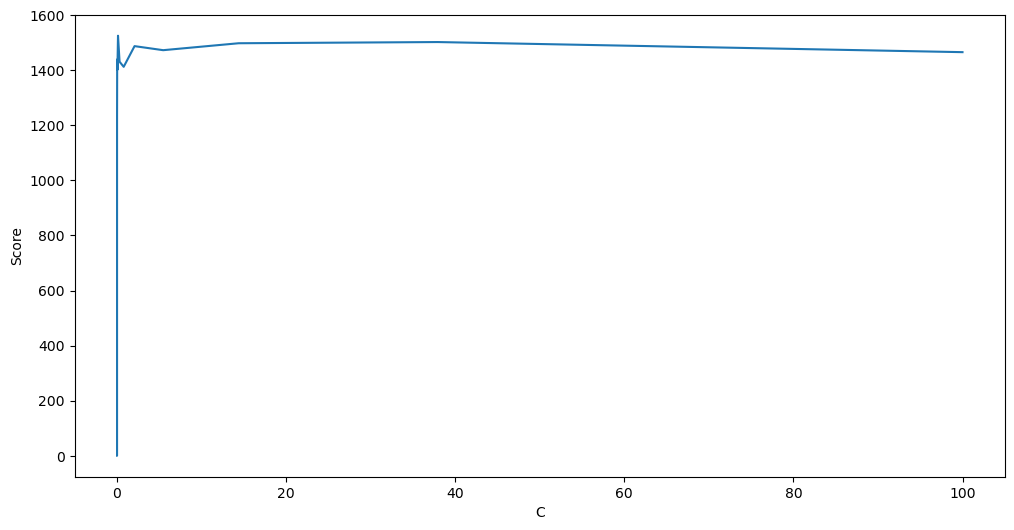

In [638]:
plt.figure(figsize=(12, 6))
plt.plot(np.logspace(-6, 2, 20), model.cv_results_["mean_test_score"])
plt.xlabel("C")
plt.ylabel("Score")
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [634]:
# your code here
for i in range(10):
    X_transformed = column_transformer.fit_transform(X)
    model = GridSearchCV(LogisticRegression(), [{"C": np.logspace(-6, 2, 20)}], scoring=make_scorer(profit_score), cv=kf)
    model.fit(X_transformed, y)
    C = model.best_params_["C"]
    print(C)

5.455594781168514
37.92690190732246
100.0
0.2976351441631313
14.384498882876601
37.92690190732246
14.384498882876601
14.384498882876601
0.11288378916846883
0.11288378916846883


#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [490]:
# your code here

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




In [ ]:
# your code here

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ # your answer here

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [ ]:
# your code here

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ # your answer here